# EDA PANADERIA SALVADOR

Hacemos los imports necesarios para este notebook

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Daily, Point
from datetime import datetime
import missingno as msno
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
import calendar

### 1. Cargamos los datos desde MySQL y preparamos los DataFrames

In [3]:
host = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com"
user = "usuario1"
password = "C0d35p4ce."
database = "sandbox"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}", pool_pre_ping=True)

# Cargar DataFrames desde MySQL
df_pedidos = pd.read_sql("SELECT * FROM dfg_pedidos", con=engine)
df_ventas = pd.read_sql("SELECT * FROM dfg_ventas", con=engine)
df_calendario = pd.read_sql("SELECT * FROM dfg_calendario", con=engine)

# Asegurar formato de fechas
df_pedidos["Fecha"] = pd.to_datetime(df_pedidos["Fecha"])


### Definimos la clase DailyWeatherData

In [5]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas climáticas importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    def __init__(self, start, end=datetime.now()):
        self.start = start
        self.end = end

    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

### Obtenemos el clima y y lo unimos a mis datos

In [6]:
# Rango de fechas de tus ventas
start = df_pedidos["Fecha"].min()
end = df_pedidos["Fecha"].max()

# Obtener datos del clima para ese rango
weather_query = DailyWeatherData(start, end)
weather = weather_query.get_weather_data()

# Unir clima con tus datos de ventas
df_clima = pd.merge(df_pedidos, weather, left_on="Fecha", right_on="time", how="inner")

# Aqui es importante que, como no lo he hecho antes en la base de datos, elimine los datos que se dijo en clase que 
# no eran necesarios, por tema del COVID.
df_clima = df_clima[df_clima["Fecha"] >= "2021-05-01"].copy() 

df_clima.drop("time", axis=1, inplace=True)

# Ordenar el DataFrame
df_clima.sort_values(["Articulo", "Fecha"], inplace=True)

# Vista previa
df_clima.head()

,Familia,Tipo,Fecha,Articulo,Cantidad,Precio,Importe,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
65777,PANADERIA,PEDIDO,2021-05-01,174,39.0,5.25,204.75,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
65835,PANADERIA,PEDIDO,2021-05-02,174,39.0,5.25,204.75,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
65894,PANADERIA,PEDIDO,2021-05-03,174,39.0,5.25,204.75,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
65950,PANADERIA,PEDIDO,2021-05-04,174,36.0,5.25,189.00,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
66003,PANADERIA,PEDIDO,2021-05-05,174,36.0,5.25,189.00,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5


#### Analizamos valores nulos

In [42]:
# Revisar posibles nulos
print(df_clima.isnull().sum())

Familia         0
Tipo            0
Fecha           0
Articulo        0
Cantidad        0
Precio          0
Importe         0
tavg_w          0
tmin_w          0
tmax_w          0
prcp_w        376
wdir_w      42128
wspd_w          0
pres_w          0
dtype: int64



Porcentaje de nulos por columna:
Familia       0.00
Tipo          0.00
Fecha         0.00
Articulo      0.00
Cantidad      0.00
Precio        0.00
Importe       0.00
tavg_w        0.00
tmin_w        0.00
tmax_w        0.00
prcp_w        0.89
wdir_w      100.00
wspd_w        0.00
pres_w        0.00
dtype: float64


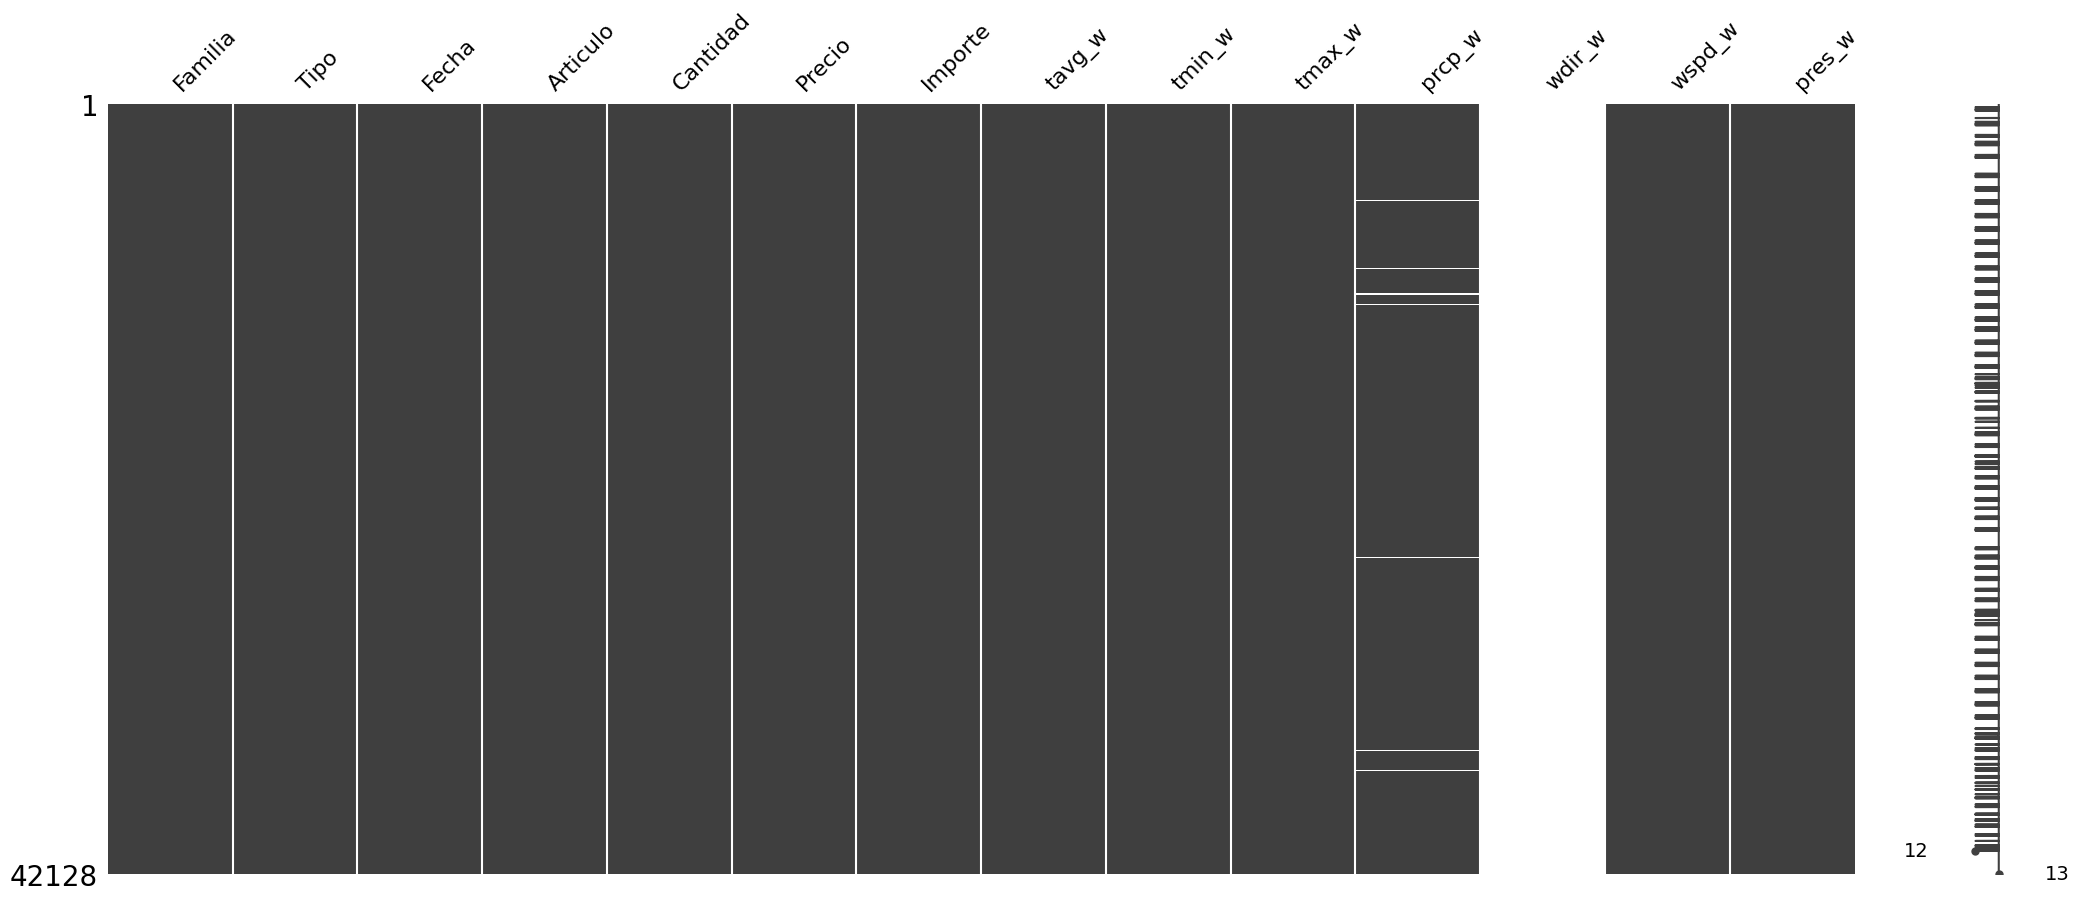

In [43]:
msno.matrix(df_clima)
# Porcentaje de nulos
print("\nPorcentaje de nulos por columna:")
print((df_clima.isnull().sum() / len(df_clima) * 100).round(2))

Como podemos ver la columna wdir_w esta completamente vacia, por ende vamos a eliminarla.

In [44]:
df_clima.drop(columns=["wdir_w"], inplace=True)

Eliminamos o rellenamos los nulos de prcp_w (precipitaciones), la opción que veo es rellenar los datos con 0mm, es decir, asumir que no llovió.

In [45]:
df_clima["prcp_w"].fillna(0, inplace=True)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




## Aqui empezaremos con el EDA, con las preguntas que nos facilitaron
Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

### 1. Describe qué significa cada fila de nuestro conjunto de datos

In [46]:
df_clima.head()

,Familia,Tipo,Fecha,Articulo,Cantidad,Precio,Importe,tavg_w,tmin_w,tmax_w,prcp_w,wspd_w,pres_w
65777,PANADERIA,PEDIDO,2021-05-01,174,39.0,5.25,204.75,17.2,11.9,22.8,0.0,14.2,1014.0
65835,PANADERIA,PEDIDO,2021-05-02,174,39.0,5.25,204.75,16.3,10.8,23.2,0.0,15.7,1015.9
65894,PANADERIA,PEDIDO,2021-05-03,174,39.0,5.25,204.75,15.3,12.7,20.1,6.5,9.7,1017.7
65950,PANADERIA,PEDIDO,2021-05-04,174,36.0,5.25,189.00,16.5,12.0,20.9,0.0,12.1,1018.0
66003,PANADERIA,PEDIDO,2021-05-05,174,36.0,5.25,189.00,16.7,12.3,21.7,0.0,13.8,1016.5


Cada fila de "df_clima" representa una venta individual de un producto Articulo en una fecha concreta con su:

- Cantidad vendida

- Precio e importe

- Información del producto (tipo, familia)

- condiciones climáticas de ese día (temperatura, precipitación, viento…)

### 2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

In [47]:
df_clima.nunique().sort_values(ascending=False)

Importe     1313
Fecha        748
Cantidad     578
tmax_w       221
pres_w       217
tmin_w       214
tavg_w       200
wspd_w       197
Articulo     156
Precio        86
prcp_w        59
Familia        3
Tipo           1
dtype: int64

In [48]:
articulo_precio = df_clima.groupby("Articulo")["Precio"].nunique().reset_index()
articulo_precio.columns = ["Articulo", "PreciosUnicos"]
art_precio_con_cambios = articulo_precio[articulo_precio["PreciosUnicos"] > 1]
art_precio_con_cambios

,Articulo,PreciosUnicos
0,174,3
1,387,4
2,417,3
3,446,2
4,498,3
...,...,...
140,9148,2
142,9161,2
143,9189,2
144,9190,2


Si un artículo tiene más de un precio, puede significar -> Promociones, cambios de coste con el tiempo o incluso errores de registro.

    

    

### 3. ¿Cuántos valores nulos hay en cada una de las variables?

In [49]:
# No se mostraran nulos porque ya los hemos rellenado o eliminado anteriormente
df_clima.isnull().sum()

Familia     0
Tipo        0
Fecha       0
Articulo    0
Cantidad    0
Precio      0
Importe     0
tavg_w      0
tmin_w      0
tmax_w      0
prcp_w      0
wspd_w      0
pres_w      0
dtype: int64

### 4. ¿Hay duplicados?

In [50]:
df_clima.duplicated().sum()

np.int64(0)

### 5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

In [51]:
min_date = df_clima["Fecha"].min()
max_date = df_clima["Fecha"].max()

print("Desde:", min_date)
print("Hasta:", max_date)

Desde: 2021-05-01 00:00:00
Hasta: 2023-05-18 00:00:00


In [61]:
# 1. Calcular el total de días disponibles en el dataset
total_dias = (df_clima["Fecha"].max() - df_clima["Fecha"].min()).days + 1

# 2. Calcular el número de días únicos registrados por producto
fechas_por_producto = df_clima.groupby("Articulo")["Fecha"].nunique().reset_index()
fechas_por_producto.columns = ["Articulo", "DiasConVenta"]

# 3. Calcular cuántos días faltan
fechas_por_producto["FechasFaltantes"] = total_dias - fechas_por_producto["DiasConVenta"]

# 4. Mostrar resultado
fechas_por_producto.head()

,Articulo,DiasConVenta,FechasFaltantes
0,174,738,10
1,387,64,684
2,417,745,3
3,446,345,403
4,498,744,4


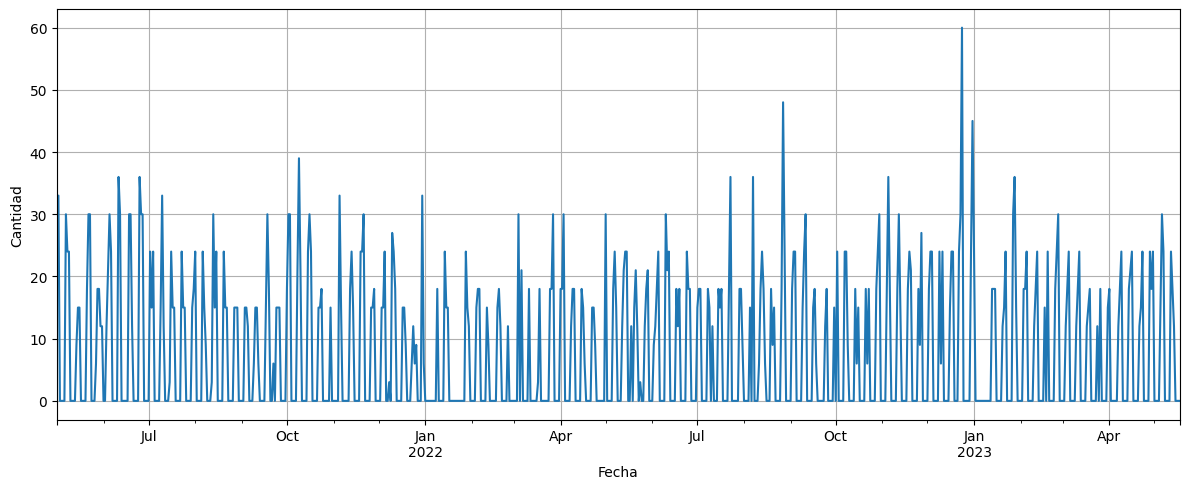

In [68]:
# Gráfico de la cantidad del producto "6549"
# Asegúrate de que la columna de fechas esté bien
df_clima["Fecha"] = pd.to_datetime(df_clima["Fecha"])

# Filtrar solo el producto 6549
articulo = 6549
df_producto = df_clima[df_clima["Articulo"] == articulo].copy()

# Agrupar por fecha (cantidad diaria)
ventas_diarias = df_producto.groupby("Fecha")["Cantidad"].sum()

# Crear un rango completo de fechas
rango_fechas = pd.date_range(start=df_clima["Fecha"].min(), end=df_clima["Fecha"].max())

# Reindexar para que se vean días sin ventas como 0
ventas_diarias = ventas_diarias.reindex(rango_fechas, fill_value=0)

# Crear gráfico
plt.figure(figsize=(12, 5))
ventas_diarias.plot()
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [ ]:
# Outliers en cantidad desglosando por producto
unique_articles = df_clima.sort_values("Familia")["Articulo"].unique().tolist()

for article in unique_articles:

    subset = df_clima.query("Articulo == @article")
    family = subset["Familia"].unique().tolist()[0]

    Q1 = subset['Cantidad'].quantile(0.25)
    Q3 = subset['Cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['Cantidad'] < (Q1 - 1.5 * IQR)) | (subset['Cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["Cantidad"]))


BOLLERIA -> Articulo 3974 -> Outliers 2
BOLLERIA -> Articulo 5794 -> Outliers 8
BOLLERIA -> Articulo 5803 -> Outliers 17
BOLLERIA -> Articulo 6626 -> Outliers 0
BOLLERIA -> Articulo 6627 -> Outliers 17
BOLLERIA -> Articulo 6624 -> Outliers 4
BOLLERIA -> Articulo 5787 -> Outliers 9
BOLLERIA -> Articulo 5773 -> Outliers 2
BOLLERIA -> Articulo 5775 -> Outliers 5
BOLLERIA -> Articulo 5809 -> Outliers 38
BOLLERIA -> Articulo 5820 -> Outliers 14
BOLLERIA -> Articulo 5804 -> Outliers 205
BOLLERIA -> Articulo 3894 -> Outliers 7
BOLLERIA -> Articulo 3960 -> Outliers 213
BOLLERIA -> Articulo 3880 -> Outliers 2
BOLLERIA -> Articulo 3874 -> Outliers 1
BOLLERIA -> Articulo 2853 -> Outliers 0
BOLLERIA -> Articulo 3860 -> Outliers 2
BOLLERIA -> Articulo 2854 -> Outliers 0
BOLLERIA -> Articulo 9328 -> Outliers 1
BOLLERIA -> Articulo 8720 -> Outliers 0
BOLLERIA -> Articulo 8910 -> Outliers 0
BOLLERIA -> Articulo 9075 -> Outliers 9
BOLLERIA -> Articulo 8719 -> Outliers 0
BOLLERIA -> Articulo 8029 -> Out

<function list.index(value, start=0, stop=9223372036854775807, /)>

#### 7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

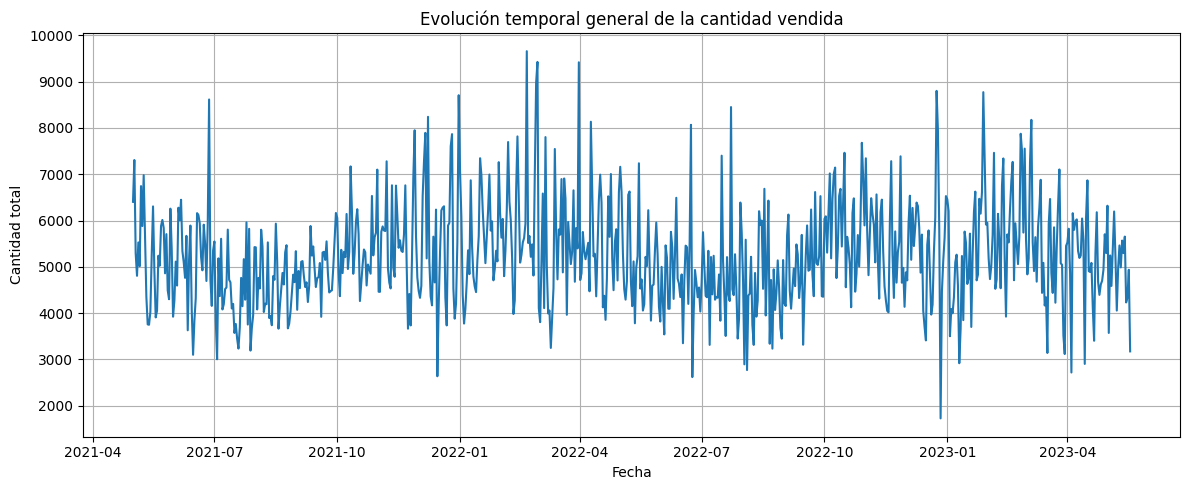

In [ ]:
# 7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

# Agrupación general por fecha
cantidad_total_diaria = df_clima.groupby("Fecha")["Cantidad"].sum().reset_index()

# Gráfico
plt.figure(figsize=(12,5))
sns.lineplot(data=cantidad_total_diaria, x="Fecha", y="Cantidad")
plt.title("Evolución temporal general de la cantidad vendida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

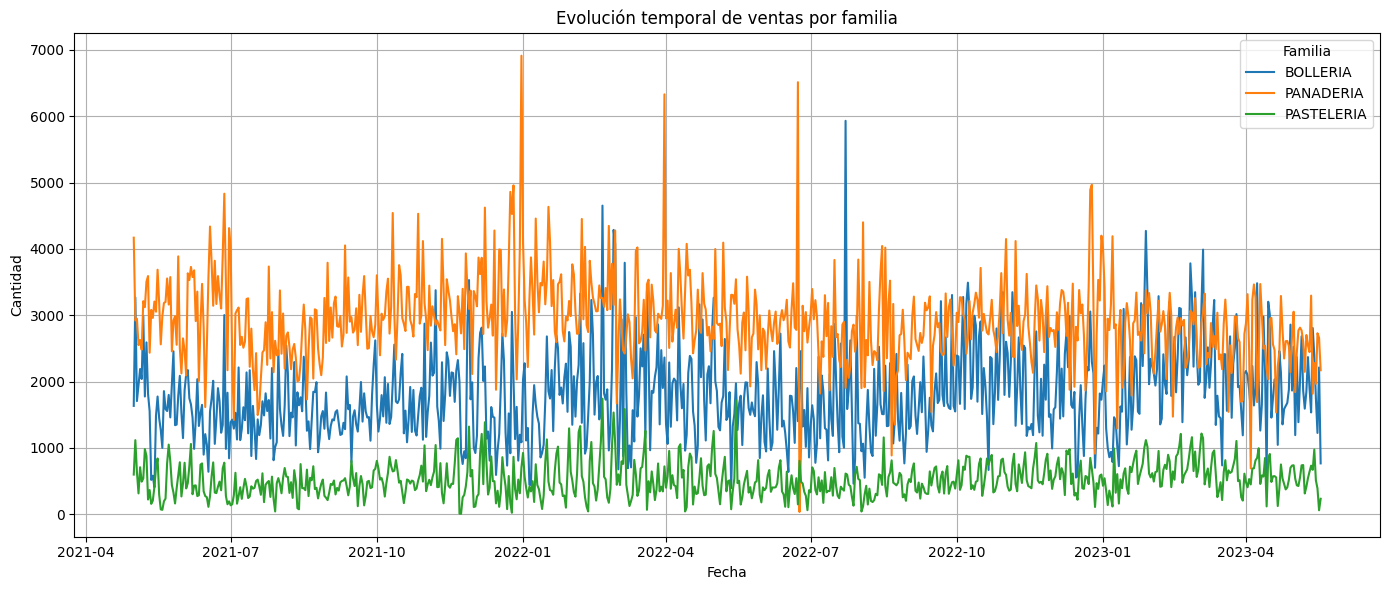

In [ ]:
# 8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

# Agrupar por fecha y familia
cantidad_familia_diaria = df_clima.groupby(["Fecha", "Familia"])["Cantidad"].sum().reset_index()

# Gráfico
plt.figure(figsize=(14,6))
sns.lineplot(data=cantidad_familia_diaria, x="Fecha", y="Cantidad", hue="Familia")
plt.title("Evolución temporal de ventas por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

/tmp/ipykernel_2291/3596343627.py:18: UserWarning:


The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.



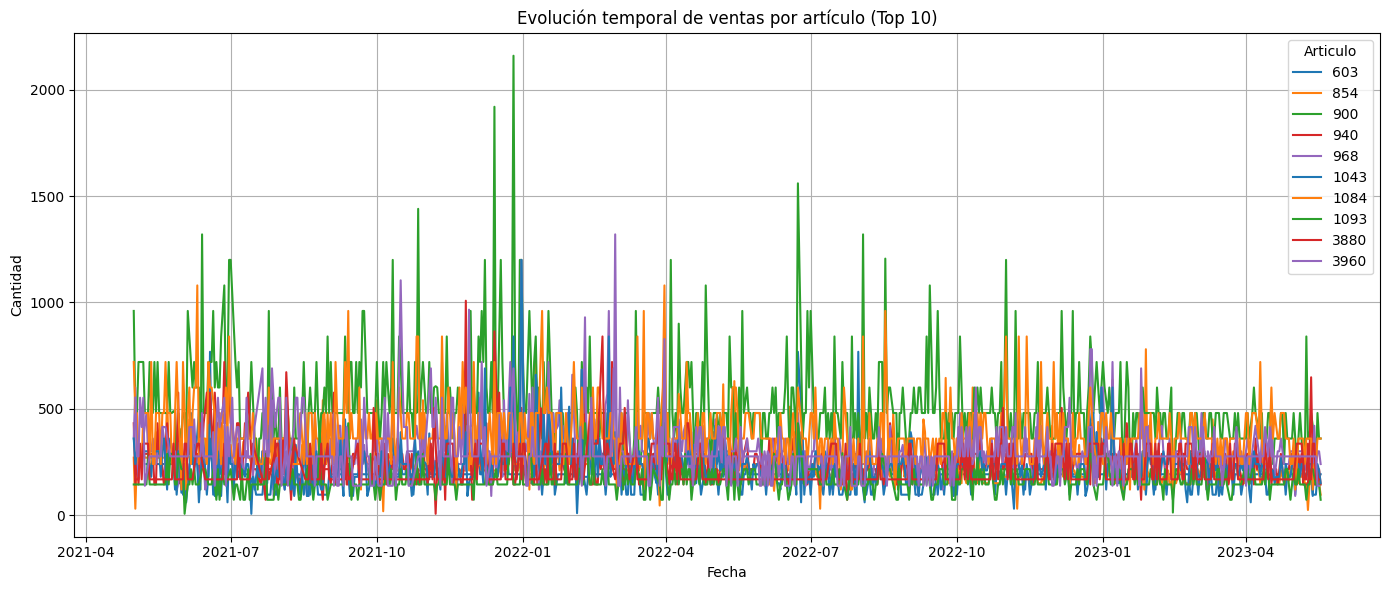

In [88]:
# 9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

# Artículos más vendidos
top_articulos = df_clima.groupby("Articulo")["Cantidad"].sum().nlargest(10).index

# Filtrar DataFrame para esos artículos
df_top_art = df_clima[df_clima["Articulo"].isin(top_articulos)]

# Agrupar por fecha y artículo
cantidad_articulo_diaria = df_top_art.groupby(["Fecha", "Articulo"])["Cantidad"].sum().reset_index()


# Lista de colores
colores_personalizados = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# Crear el gráfico con colores definidos
plt.figure(figsize=(14,6))
sns.lineplot(
    data=cantidad_articulo_diaria,
    x="Fecha",
    y="Cantidad",
    hue="Articulo",
    palette=colores_personalizados
)

plt.title("Evolución temporal de ventas por artículo (Top 10)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()



#### 10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?
A simple vista, no se observa una tendencia como tal y diria que tampoco estacionalidad en la evolución dtemporal de los 10 articulos más vendidos (he escogido 10 articulos porque creo que poner todos es demasiada información)

#### 11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

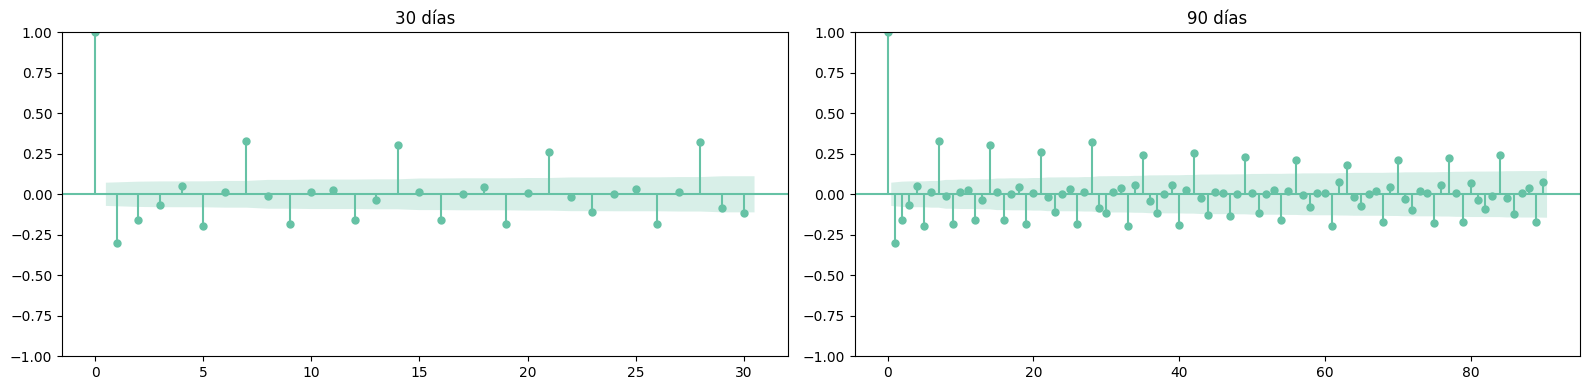

In [97]:
# Agrupar todas las ventas por fecha
cantidad_diaria = df_clima.groupby("Fecha")["Cantidad"].sum()

# Tomar la primera diferencia (para hacer la serie más "estacionaria")
cantidad_diff = cantidad_diaria.diff().dropna()

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # 1 fila, 2 columnas

#  Autocorrelación (ACF) con statsmodels
# Utilizamos la autocorrelación para ver la relación entre las observaciones de la serie temporal en diferentes momento
# si escogieramos un gafico lineal, muestra la evolución de las ventas, pero no nos dice si hay patrones repetitivos en el tiempo
# (A SIMPLE VISTA SI PODRIAMOS OBSERVAR SI HAY O NO ESOS PATRONES, PERO NO ES LO MEJOR)

# ACF con 30 lags (para hacer una autocorrelacion de 30 dias y ver patrones semanales)
plot_acf(cantidad_diff, lags=30, ax=axes[0])
axes[0].set_title("30 días")

# ACF con 90 lags (para hacer una autocorrelacion de 90 dias y ver patrones mensuales i/o trimestrales)
plot_acf(cantidad_diff, lags=90, ax=axes[1])
axes[1].set_title("90 días")

plt.tight_layout()
plt.show()




#### 12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

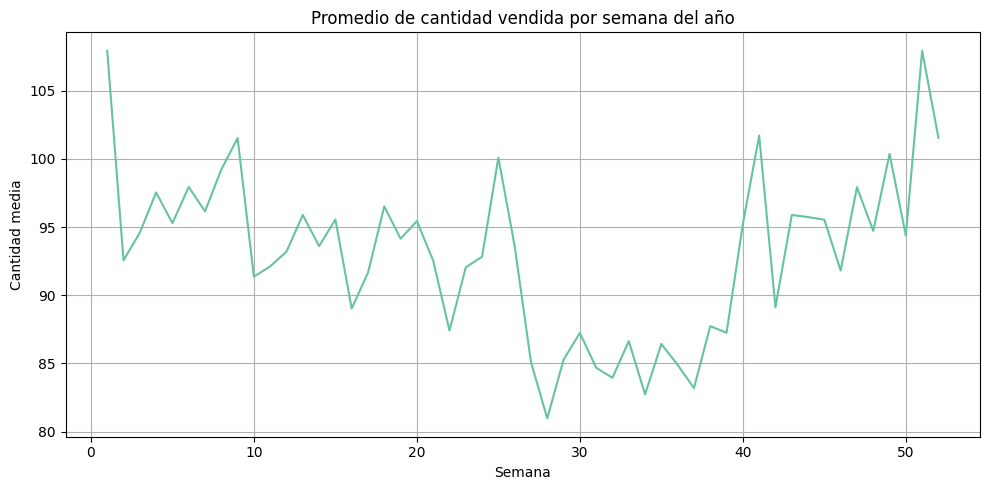

In [103]:
# 12
# Creamos columnas basadas en la fecha
df_clima["Semana"] = df_clima["Fecha"].dt.isocalendar().week
df_clima["Mes"] = df_clima["Fecha"].dt.month
df_clima["DiaSemana"] = df_clima["Fecha"].dt.day_name()
df_clima["DiaMes"] = df_clima["Fecha"].dt.day
df_clima["DiaAnio"] = df_clima["Fecha"].dt.dayofyear

# Agrupación por semana del año (para detectar estacionalidad semanal)
semanal = df_clima.groupby("Semana")["Cantidad"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=semanal, x="Semana", y="Cantidad")
plt.title("Promedio de cantidad vendida por semana del año")
plt.xlabel("Semana")
plt.ylabel("Cantidad media")
plt.grid(True)
plt.tight_layout()
plt.show()

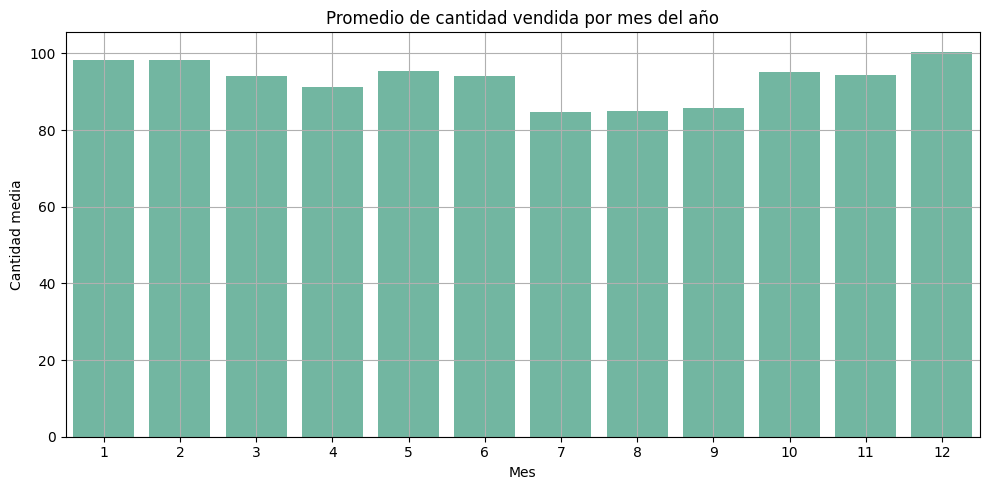

In [104]:
mensual = df_clima.groupby("Mes")["Cantidad"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=mensual, x="Mes", y="Cantidad")
plt.title("Promedio de cantidad vendida por mes del año")
plt.xlabel("Mes")
plt.ylabel("Cantidad media")
plt.grid(True)
plt.tight_layout()
plt.show()

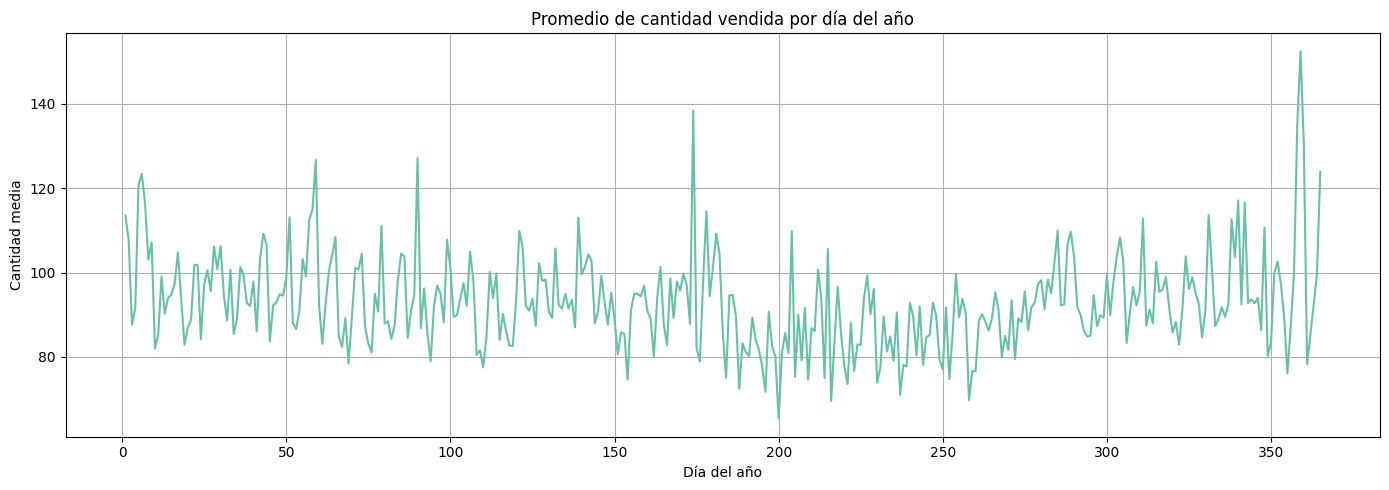

In [105]:
diario_anual = df_clima.groupby("DiaAnio")["Cantidad"].mean().reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=diario_anual, x="DiaAnio", y="Cantidad")
plt.title("Promedio de cantidad vendida por día del año")
plt.xlabel("Día del año")
plt.ylabel("Cantidad media")
plt.grid(True)
plt.tight_layout()
plt.show()

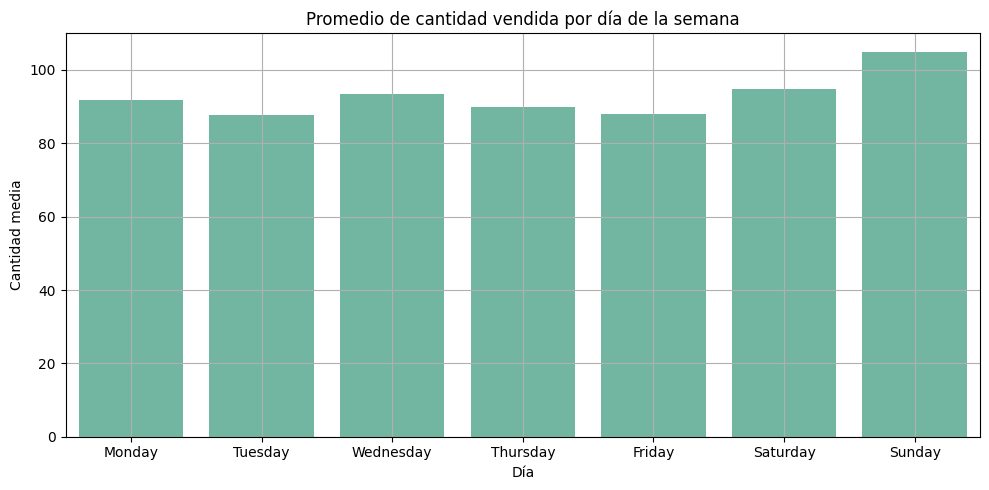

In [106]:
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dia_semana = df_clima.groupby("DiaSemana")["Cantidad"].mean().reindex(orden_dias).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=dia_semana, x="DiaSemana", y="Cantidad")
plt.title("Promedio de cantidad vendida por día de la semana")
plt.xlabel("Día")
plt.ylabel("Cantidad media")
plt.grid(True)
plt.tight_layout()
plt.show()

Parece que los graficos confirman lo que mostró la autocorrelación que hicimos en la pregunta 11, pero de forma visual y mucho más específica.

Cantidad total general (semanas 51–52)

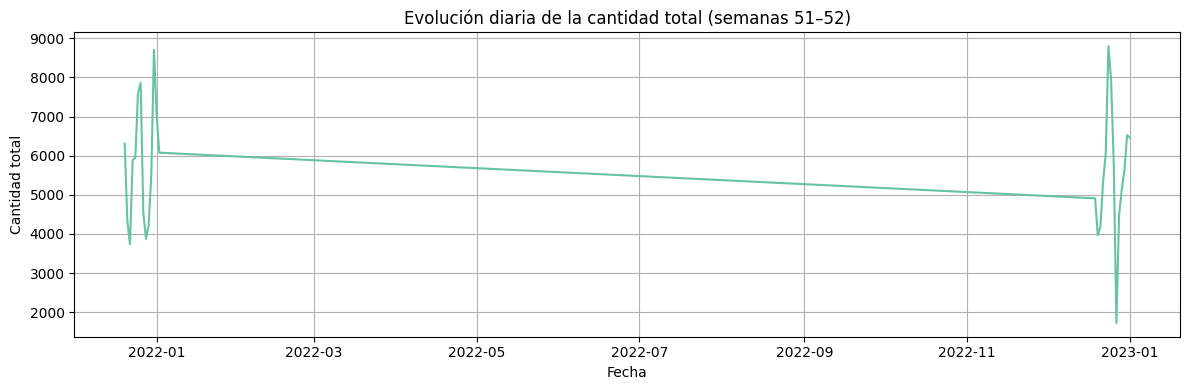

In [120]:
# Filtrar semanas 51–52
df_pico_semanal = df_clima[df_clima["Semana"].isin([51, 52])]

# Agrupar por fecha
cantidad_general = df_pico_semanal.groupby("Fecha")["Cantidad"].sum().reset_index()

# Gráfico
plt.figure(figsize=(12, 4))
sns.lineplot(data=cantidad_general, x="Fecha", y="Cantidad")
plt.title("Evolución diaria de la cantidad total (semanas 51–52)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total")
plt.grid(True)
plt.tight_layout()
plt.show()

Cantidad por familia

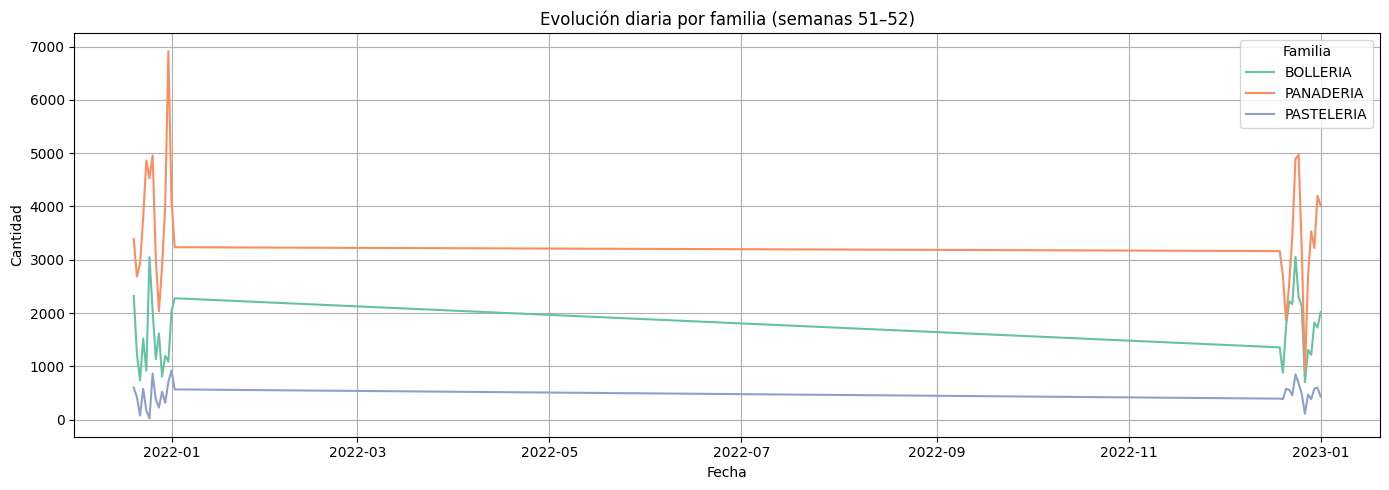

In [121]:
# Agrupar por fecha y familia
cantidad_familia = df_pico_semanal.groupby(["Fecha", "Familia"])["Cantidad"].sum().reset_index()

# Gráfico
plt.figure(figsize=(14, 5))
sns.lineplot(data=cantidad_familia, x="Fecha", y="Cantidad", hue="Familia")
plt.title("Evolución diaria por familia (semanas 51–52)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

Cantidad por artículo

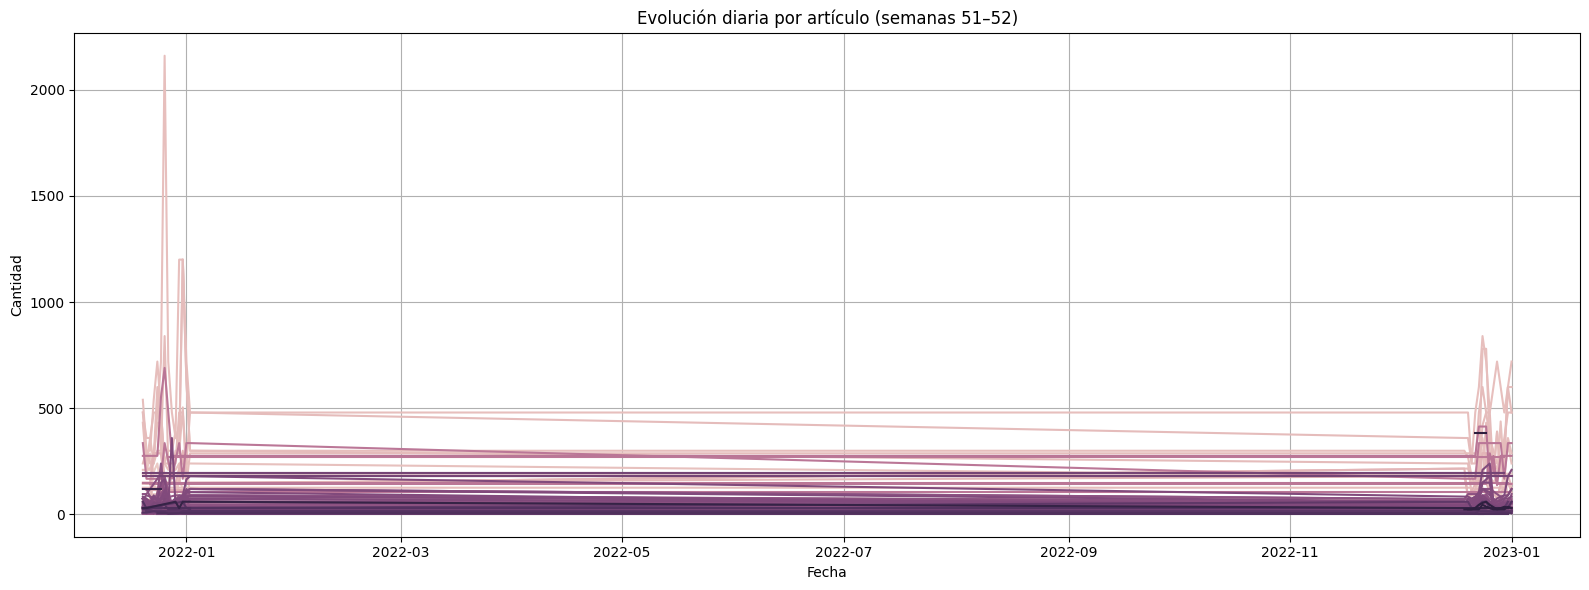

In [122]:
# Agrupar por fecha y artículo
cantidad_articulo = df_pico_semanal.groupby(["Fecha", "Articulo"])["Cantidad"].sum().reset_index()

# Gráfico
plt.figure(figsize=(16, 6))
sns.lineplot(data=cantidad_articulo, x="Fecha", y="Cantidad", hue="Articulo", legend=False)
plt.title("Evolución diaria por artículo (semanas 51–52)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

Como no he hecho lo de los festivos anteriormente en mi dataframe, lo voy a hacer ahora

In [8]:
df_calendario["EsFestivo"] = df_calendario["Festivo"].notna()

In [9]:
print(df_calendario[["Fecha", "Festivo", "EsFestivo"]].head())

       Fecha              Festivo  EsFestivo
0 2017-01-01            Año Nuevo       True
1 2017-01-06         Día de Reyes       True
2 2017-02-14  Día de San Valentín       True
3 2017-03-19        Día del Padre       True
4 2017-04-09     Domingo de Ramos       True


In [10]:
df_calendario["Fecha"] = pd.to_datetime(df_calendario["Fecha"])
df_clima["Fecha"] = pd.to_datetime(df_clima["Fecha"])
df_clima = df_clima.merge(df_calendario[["Fecha", "EsFestivo"]], on="Fecha", how="left")

In [11]:
print(df_clima.columns)
df_clima["EsFestivo"].value_counts(dropna=False)

Index(['Familia', 'Tipo', 'Fecha', 'Articulo', 'Cantidad', 'Precio', 'Importe',
       'tavg_w', 'tmin_w', 'tmax_w', 'prcp_w', 'wdir_w', 'wspd_w', 'pres_w',
       'EsFestivo'],
      dtype='object')


EsFestivo
NaN     38724
True     3468
Name: count, dtype: int64

#### 13. ¿El comportamiento de compra (la variable cantidad) cuando es festivo es superior a cuando no lo es?

In [32]:
# 1. Eliminar columnas duplicadas si existen
df_clima.drop(columns=["es_festivo", "es_festivo_x", "es_festivo_y"], errors="ignore", inplace=True)

# 2. Crear columna es_festivo en el calendario
df_calendario["es_festivo"] = df_calendario["Festivo"].notna().astype(int)

# 3. Filtrar calendario para que coincida con las fechas de clima
fecha_min = df_clima["Fecha"].min()
fecha_max = df_clima["Fecha"].max()

df_calendario_filtrado = df_calendario[
    (df_calendario["Fecha"] >= fecha_min) & 
    (df_calendario["Fecha"] <= fecha_max)
]

# 4. Merge final sin conflicto
df_clima = df_clima.merge(df_calendario_filtrado[["Fecha", "es_festivo"]], on="Fecha", how="left")

# 5. Rellenar días no festivos con 0
df_clima["es_festivo"].fillna(0, inplace=True)
df_clima["es_festivo"] = df_clima["es_festivo"].astype(int)

/tmp/ipykernel_133653/97126268.py:20: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [33]:
df_clima["es_festivo"].value_counts()

es_festivo
0    38724
1     5388
Name: count, dtype: int64

In [34]:
fig = px.box(df_clima, x="es_festivo", y="Cantidad", color="Familia",
             labels={"es_festivo": "¿Es festivo?", "Cantidad": "Cantidad vendida"},
             title="Ventas por familia: festivo vs no festivo")
fig.show()

#### 14. ¿El comportamiento de compra (la variable Cantidad) cuando llueve es superior a cuando no llueve?

In [35]:
# Crear variable binaria: llueve o no
df_clima["Llueve"] = df_clima["prcp_w"].apply(lambda x: 1 if x > 0 else 0)

# Gráfico boxplot
import plotly.express as px

fig = px.box(df_clima, x="Llueve", y="Cantidad", color="Familia",
             labels={"Llueve": "¿Llueve?", "Cantidad": "Cantidad vendida"},
             title="Ventas por familia: llueve vs no llueve")
fig.show()

A simple vista, la cantidad vendida disminuye cuando llueve. El comportamiento de compra parece estar influido por la presencia de lluvia, pero tampoco algo muy extremista, simplemente un poco de nada.

#### 15. Divide la variable tavg_w (temperatura media) en quintiles y muestra con un gráfico de barras si la cantidad es superior en alguno de sus quintiles.

In [38]:
labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df_clima['quintiles_tavg_w'] = pd.qcut(df_clima['tavg_w'], q=5, labels=labels_tavg)

group = df_clima.groupby(["Familia", "quintiles_tavg_w"])["Cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='Cantidad', color="Familia",barmode='group')
fig.show()

/tmp/ipykernel_133653/1053888524.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### 16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

In [39]:
# Calcular correlación precio-cantidad por artículo
correlaciones = df_clima.groupby("Articulo")[["Precio", "Cantidad"]].corr().iloc[0::2,-1].reset_index()
correlaciones = correlaciones[["Articulo", "Cantidad"]]  # esta columna representa la correlación Precio vs Cantidad
correlaciones.columns = ["Articulo", "Correlacion_Precio_Cantidad"]

# Mostrar las correlaciones más negativas (cuando sube el precio, baja la cantidad)
correlaciones.sort_values("Correlacion_Precio_Cantidad").head(10)

,Articulo,Correlacion_Precio_Cantidad
27,2101,-0.644658
76,6008,-0.582803
0,174,-0.551016
79,6053,-0.404102
69,5809,-0.357488
7,854,-0.335465
127,8015,-0.313527
11,924,-0.270662
119,7800,-0.249731
68,5804,-0.245957
